In [56]:
from collections import Counter

import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import gc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics._plot.confusion_matrix \
    import ConfusionMatrixDisplay

def plot_confusion_matrix(estimator, X, y_true, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None,
                          cmap='viridis', ax=None):


    y_pred = estimator.predict(X)
    y_pred = (y_pred >= .3).astype(np.int8)
    
    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

In [57]:
Xy = pd.read_csv('train.csv')
X, y = Xy.iloc[:, :-1], Xy.iloc[:, -1]
data_test = pd.read_csv('test.csv')

In [58]:
Xy.drop('id', axis=1, inplace=True)
data_test.drop('id', axis=1, inplace=True)

### Primeiramente, vejamos os nomes das colunas bem como quais os respectivos tipos de dados.

In [59]:
for c in Xy.columns:
    print(c, 'dtype:', Xy[c].dtype)

bin_0 dtype: int64
bin_1 dtype: int64
bin_2 dtype: int64
bin_3 dtype: object
bin_4 dtype: object
nom_0 dtype: object
nom_1 dtype: object
nom_2 dtype: object
nom_3 dtype: object
nom_4 dtype: object
nom_5 dtype: object
nom_6 dtype: object
nom_7 dtype: object
nom_8 dtype: object
nom_9 dtype: object
ord_0 dtype: int64
ord_1 dtype: object
ord_2 dtype: object
ord_3 dtype: object
ord_4 dtype: object
ord_5 dtype: object
day dtype: int64
month dtype: int64
target dtype: int64


Note-se que há atributos não-numéricos na base. Portanto, é necessário um mapeamento desses atributos para números uma vez que o **xgboost só trabalha com atributos numéricos**.
Então...
## Hora de fazer o encoding para executar o xgboost sobre os dados

Abaixo, a (extremamaneto simplificada) função responsável por esse mmapeamento.  
Basicamente, para cada atributo não-numérico (nesta base, são todos do tipo *object*) que é também _nominal_, cria-se *n* colunas, 

In [60]:
def dummy_df_encoder(data,
    encoder_ord=LabelEncoder(),
    ord_dict={}):
    _ = data.copy()
    for c, dt in zip(_.columns, _.dtypes):
        v = _[c]
        if dt == 'object':
            if c.startswith('nom_'):
                if len(v.unique()) < 10:
                    _[ v.unique() ] = pd.get_dummies(v)
                    _.drop(c, axis=1, inplace=True)
                else:
                    _[c] = encoder_ord.fit_transform(v)
            else:
                if c in ord_dict:
                    _[c] = pd.Categorical(
                                v,categories=ord_dict[c], ordered=True
                            ).codes
                else:
                    _[c] = pd.Categorical(
                                v,categories=v.unique(), ordered=True
                            ).codes                    
    return _


Por haverem atributos ordinais, faz sentido convertê-los para números que mantém a relação de ordem estabelecida na base original. Entretanto, o grupo apenas foi capaz de estabelecer relações de ordem a 2 atributos ordinais: **ord_1** e **ord_2**. Portanto, os outros atributos ordinais foram transformados em números que não preservam seja lá qual fosse a relação de ordem original.

In [61]:
# Ordem entre os atributos ordinais
ordering_dict = {
    'ord_1': [
        'Novice',
        'Contributor',
        'Expert',
        'Master',
        'Grandmaster'],
    'ord_2': [
        'Freezing',
        'Cold',
        'Warm',
        'Hot',
        'Boiling Hot',
        'Lava Hot'],
}

### Transformação da base original para uma cujos atributos são todos numéricos.

In [62]:
%%time
train_encoded = dummy_df_encoder( X.drop('id', axis=1),
                                 ord_dict=ordering_dict
                                )

CPU times: user 1.05 s, sys: 95.9 ms, total: 1.15 s
Wall time: 1.22 s


### Separação dos dados em conjunto de treinamento e teste.

In [63]:
%%time
X_train, X_test, y_train, y_test = train_test_split(
    train_encoded, y, test_size=.2, random_state=42
)

CPU times: user 89 ms, sys: 3.95 ms, total: 93 ms
Wall time: 114 ms


## Preparação do formato dos dados
Para a utilização do xgboost por meio de sua interface nativa, é preciso antes converter os dados de treinamento e teste para formatos específicos da biblioteca. Essas transformações são realizadas na célula abaixo

In [64]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

## Preparação dos parâmetros
A função **xgboost.train** recebe os parâmetros para o *booster* na forma de um dicionário (conforme variável *best_param*). Outros parâmetros podem ser passados, como por exemplo conjuntos a serem utilizados como teste a fim de que o treinamento de encerre antes do limite estipulado por *num_boost_round* caso a performance do modelo quando aplicado a esses conjuntos de testes deixe de aumentar após *early_stopping_rounds* árvores adicionadas ao modelo.

In [65]:
eval_set = [
    (dtest, 'test')
]

best_param = {
    'max_depth':3,
    'eta':1,
    'objective':'binary:logistic',    
}
num_boost_round = 100
early_stopping_rounds = 20

## Finalmente, trainamos o modelo.

In [66]:
model = xgb.train(
    best_param,
    dtrain,
    num_boost_round,
    early_stopping_rounds=early_stopping_rounds,
    evals=eval_set
)

[0]	test-error:0.30538
Will train until test-error hasn't improved in 20 rounds.
[1]	test-error:0.29615
[2]	test-error:0.29203
[3]	test-error:0.28897
[4]	test-error:0.28657
[5]	test-error:0.28477
[6]	test-error:0.28308
[7]	test-error:0.28032
[8]	test-error:0.27963
[9]	test-error:0.27817
[10]	test-error:0.27643
[11]	test-error:0.27608
[12]	test-error:0.27418
[13]	test-error:0.27355
[14]	test-error:0.27357
[15]	test-error:0.27183
[16]	test-error:0.27120
[17]	test-error:0.27088
[18]	test-error:0.27067
[19]	test-error:0.27030
[20]	test-error:0.27003
[21]	test-error:0.26848
[22]	test-error:0.26662
[23]	test-error:0.26592
[24]	test-error:0.26563
[25]	test-error:0.26573
[26]	test-error:0.26500
[27]	test-error:0.26500
[28]	test-error:0.26460
[29]	test-error:0.26335
[30]	test-error:0.26355
[31]	test-error:0.26328
[32]	test-error:0.26305
[33]	test-error:0.26213
[34]	test-error:0.26192
[35]	test-error:0.26200
[36]	test-error:0.26082
[37]	test-error:0.26022
[38]	test-error:0.26040
[39]	test-error:

## O modelo retornado por xgb.train não é o melhor, mas sim o último.

Portanto, devemos treinar novamente o modelo porém apenas até a n-ésima iteração. Neste caso, n=67.

In [67]:
%%time
best = xgb.train(best_param, dtrain, model.best_iteration + 1,
                evals=eval_set, verbose_eval=0
)

CPU times: user 38.8 s, sys: 8.04 ms, total: 38.8 s
Wall time: 4.91 s


### A seguir, resultados obtidos a partir de interpretação das probabilidades produzidas pelo modelo de acordo com diversos limiares (*threshold*).

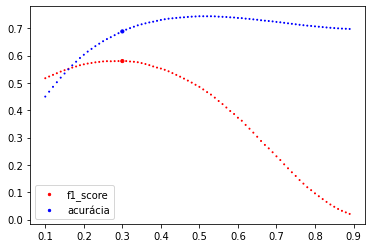

thresh: 0.3, f1_score: 0.5802, accuracy: 0.68867
CPU times: user 2.28 s, sys: 104 ms, total: 2.38 s
Wall time: 1.92 s


In [71]:
%%time
preds = best.predict(dtest)
thresh_lis = []
accuracy_lis = []
f1_lis = []
pred_lis = []
for prob in np.arange(0.1, 0.9, .01):
    pred_lis.append(preds)
    discretized_preds = (preds >= prob).astype(np.int8)
    thresh_lis.append(prob)
    accuracy_lis.append(accuracy_score(y_test, discretized_preds))
    f1_lis.append(f1_score(y_test, discretized_preds))


area = np.ones(len(thresh_lis))
area[f1_lis.index(max(f1_lis))] = 10
# Ponto com maior f1_score e sua respectiva acurácia

plt.scatter(thresh_lis, f1_lis, s=area, c='red')
plt.scatter(thresh_lis, accuracy_lis, s=area, c='blue')

plt.legend(['f1_score', 'acurácia'])
plt.show()
ma = max(f1_lis)
ima = f1_lis.index(ma)
print('thresh: {:.4}, f1_score: {:.4f}, accuracy: {:.5f}'.format(
    thresh_lis[ima], f1_lis[ima], accuracy_lis[ima]))

## Abaixo, a matriz de confusão correspondente ao melhor resultado acima

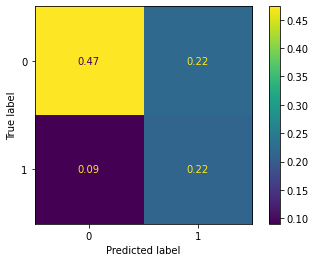

In [72]:
plot_confusion_matrix(
    best, dtest, y_test, labels=[0, 1], normalize='all'
);

Claramente, não são bons resultados: temos uma acurária < 70% e f1_score ainda mais baixo, conforme mostrado no plot poucas células acima.